# 02 — Data Cleaning & Feature Engineering

## Libraries

In [2]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler, RobustScaler
from joblib import dump

## Config

In [3]:
mpl.rcParams["figure.figsize"] = (10, 4)
mpl.rcParams["axes.titlesize"] = 13
mpl.rcParams["axes.labelsize"] = 11
mpl.rcParams["font.family"] = "DejaVu Sans"
mpl.rcParams["axes.prop_cycle"] = plt.cycler(color=["#DB1EE5","#FFC107","#43A047","#E53935"])
mpl.rcParams["grid.alpha"] = 0.3
mpl.rcParams["axes.grid"] = True

# Paths
DATA_PATH = Path("../data/Data_ElPaso_Clean.csv")   
OUT_DIR   = Path("../outputs/data"); OUT_DIR.mkdir(parents=True, exist_ok=True)
ART_DIR   = Path("../outputs/artifacts"); ART_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR   = Path("../outputs/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

# Timezone of the index in the CSV is expected to be UTC (e.g., "…+00:00").
TARGET_COL = "GHI"
TIMEZONE_LOCAL = "America/Bogota"   # optional if you want local-time features
BASE_FREQ = "10T"                   # expected uniform sampling

## Load + integrity check

In [4]:
df = pd.read_csv(DATA_PATH, parse_dates=[0], index_col=0)
df.index.name = "time"

print(df.info())
display(df.head())

# Sort, drop duplicated timestamps
df = df.sort_index()
dup_count = df.index.duplicated().sum()
if dup_count:
    print(f"[WARN] Dropping {dup_count} duplicated timestamps")
    df = df[~df.index.duplicated(keep="first")]

# Check monotonicity & rough frequency
print("Time span:", df.index.min(), "→", df.index.max())
print("Inferred freq (first 500 rows):", pd.infer_freq(df.index[:500]) or "irregular/unknown")


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 107172 entries, 2022-02-21 18:00:00+00:00 to 2024-03-06 23:50:00+00:00
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   CSI      107172 non-null  float64
 1   GHI      107172 non-null  float64
 2   Presion  107172 non-null  float64
 3   TempAmb  107172 non-null  float64
 4   Wind Y   107172 non-null  float64
 5   Wind X   107172 non-null  float64
 6   DoY Sin  107172 non-null  float64
 7   DoY Cos  107172 non-null  float64
 8   horas    107172 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 8.2 MB
None


,CSI,GHI,Presion,TempAmb,Wind Y,Wind X,DoY Sin,DoY Cos,horas
time,,,,,,,,,
2022-02-21 18:00:00+00:00,2.0,3.0352,1000.7912,29.9672,2.832954,-0.093612,0.778764,0.627317,18
2022-02-21 18:10:00+00:00,0.0,0.3562,1000.9321,29.5689,3.387552,0.796801,0.778764,0.627317,18
2022-02-21 18:20:00+00:00,0.0,0.0000,1001.1479,29.2593,2.091197,-0.878680,0.778764,0.627317,18
2022-02-21 18:30:00+00:00,0.0,0.0000,1001.2992,28.9183,-0.487957,-1.478562,0.778764,0.627317,18
2022-02-21 18:40:00+00:00,0.0,0.0000,1001.4676,28.5578,0.891171,-2.047462,0.778764,0.627317,18


Time span: 2022-02-21 18:00:00+00:00 → 2024-03-06 23:50:00+00:00
Inferred freq (first 500 rows): 10min


## Regularize 

In [5]:
# Build a full 10-min grid and reindex
full_idx = pd.date_range(df.index.min(), df.index.max(), freq=BASE_FREQ, tz=df.index.tz)
df = df.reindex(full_idx)
df.index.name = "time"

# Gap report
missing_rows = df.isna().all(axis=1).sum()
print(f"Grid size: {len(df):,} | Fully-missing rows after reindex: {missing_rows:,}")

# Optional: also keep a missingness mask for TARGET_COL to avoid accidental leakage
df["__missing_target"] = df[TARGET_COL].isna()

Grid size: 107,172 | Fully-missing rows after reindex: 0


C:\Users\Esteban\AppData\Local\Temp\ipykernel_17396\1245140973.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_idx = pd.date_range(df.index.min(), df.index.max(), freq=BASE_FREQ, tz=df.index.tz)


## Flagging 

In [6]:
def flag_range(s, lo=None, hi=None):
    ok = pd.Series(True, index=s.index)
    if lo is not None:
        ok &= s >= lo
    if hi is not None:
        ok &= s <= hi
    return ~ok  # True if outlier

flags = {}

# Conservative ranges — adjust to your context if needed
flags["flag_GHI_range"]      = flag_range(df["GHI"],      lo=0,   hi=1300)         # W/m²
flags["flag_TempAmb_range"]  = flag_range(df["TempAmb"],  lo=-10, hi=60)           # °C (wide)
flags["flag_Presion_range"]  = flag_range(df["Presion"],  lo=850, hi=1100)         # hPa (wide)
# Wind components: allow wide numeric, sanity is optional here
# CSI often in [0, ~2]; flag extreme values if present
if "CSI" in df.columns:
    flags["flag_CSI_range"]  = flag_range(df["CSI"],      lo=0.0, hi=2.5)

for k, v in flags.items():
    df[k] = v

print({k:int(v.sum()) for k,v in flags.items()})


{'flag_GHI_range': 0, 'flag_TempAmb_range': 0, 'flag_Presion_range': 0, 'flag_CSI_range': 0}


## Local time features and encoding

In [7]:
base = df.copy()
# If index is UTC, derive local time features; else skip conversion
idx_local = base.index.tz_convert(TIMEZONE_LOCAL) if base.index.tz is not None else base.index

base["hour"]     = idx_local.hour
base["dow"]      = idx_local.dayofweek       # 0=Mon
base["month"]    = idx_local.month
base["minute"]   = idx_local.minute
base["is_weekend"] = base["dow"].isin([5,6]).astype(int)

# Cyclical encodings (even if you already have DoY Sin/Cos, ensure hour too)
base["hour_sin"] = np.sin(2*np.pi*base["hour"]/24)
base["hour_cos"] = np.cos(2*np.pi*base["hour"]/24)

# If DoY Sin/Cos exist, keep; else compute day-of-year
if not {"DoY Sin","DoY Cos"}.issubset(base.columns):
    doy = idx_local.dayofyear
    base["DoY Sin"] = np.sin(2*np.pi*doy/365.25)
    base["DoY Cos"] = np.cos(2*np.pi*doy/365.25)


## Wind

In [8]:
if {"Wind X","Wind Y"}.issubset(base.columns):
    base["WindSpeed"]    = np.sqrt(base["Wind X"]**2 + base["Wind Y"]**2)
    base["WindDirection"] = (np.degrees(np.arctan2(base["Wind X"], base["Wind Y"])) + 360) % 360


## Lags

In [9]:
# Define windows in number of 10-min steps
win_1h  = 6
win_3h  = 18
win_6h  = 36

roll_vars = [TARGET_COL, "TempAmb", "Presion", "WindSpeed"] if "WindSpeed" in base.columns else [TARGET_COL, "TempAmb", "Presion"]

for v in roll_vars:
    if v in base.columns:
        base[f"{v}_roll1h_mean"] = base[v].rolling(win_1h, min_periods=win_1h//2).mean()
        base[f"{v}_roll3h_mean"] = base[v].rolling(win_3h, min_periods=win_3h//2).mean()
        base[f"{v}_roll6h_mean"] = base[v].rolling(win_6h, min_periods=win_6h//2).mean()
        base[f"{v}_roll1h_max"]  = base[v].rolling(win_1h, min_periods=win_1h//2).max()

# Lags to capture short-memory dynamics (10m, 30m, 1h, 2h, 6h)
lags = [1, 3, 6, 12, 36]
for L in lags:
    base[f"{TARGET_COL}_lag{L}"] = base[TARGET_COL].shift(L)


## Plots

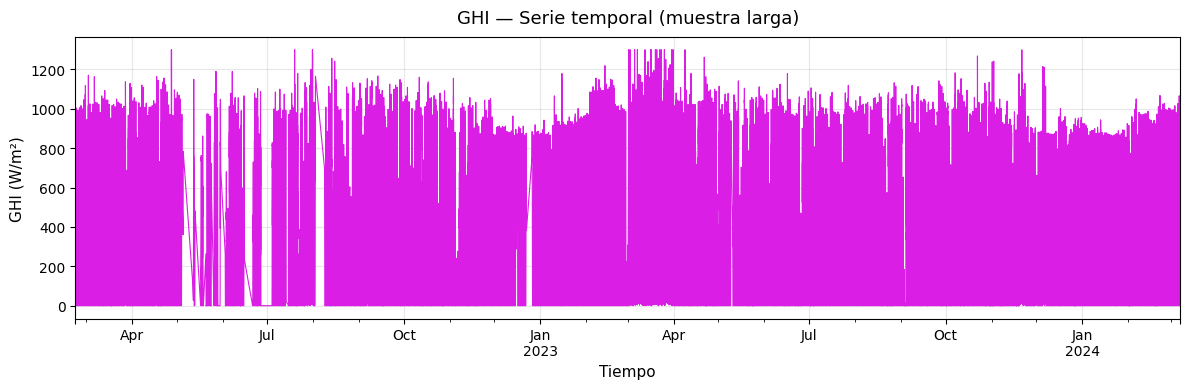

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
base["GHI"].plot(ax=ax, lw=0.8)
ax.set_xlabel("Tiempo")
ax.set_ylabel("GHI (W/m²)")
ax.set_title("GHI — Serie temporal (muestra larga)", pad=10)
fig.tight_layout()
fig.savefig(FIG_DIR / "ghi_timeseries_long.png")
plt.show()


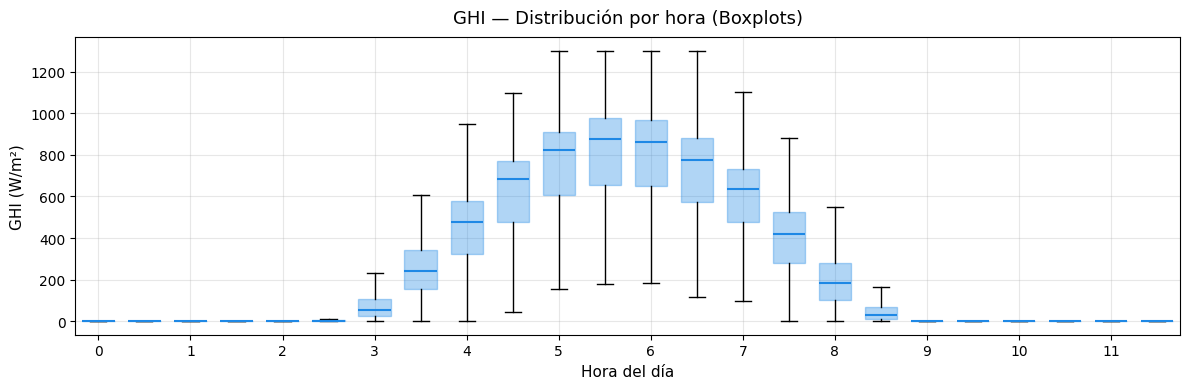

In [11]:

tmp = base.copy()
tmp["hour"] = tmp.index.hour
mat = [tmp.loc[tmp["hour"]==h, "GHI"].dropna().values for h in range(24)]

fig, ax = plt.subplots(figsize=(12,4))
bp = ax.boxplot(mat, positions=np.arange(24), showfliers=False, widths=0.7,
                patch_artist=True)
for box in bp["boxes"]:
    box.set(facecolor="#1E88E5", alpha=0.35, edgecolor="#1E88E5")
for med in bp["medians"]:
    med.set(color="#1E88E5", linewidth=1.5)

ax.set_xticks(range(0,24,2))
ax.set_xlabel("Hora del día")
ax.set_ylabel("GHI (W/m²)")
ax.set_title("GHI — Distribución por hora (Boxplots)", pad=10)
fig.tight_layout()
fig.savefig(FIG_DIR / "ghi_boxplot_by_hour.png")
plt.show()


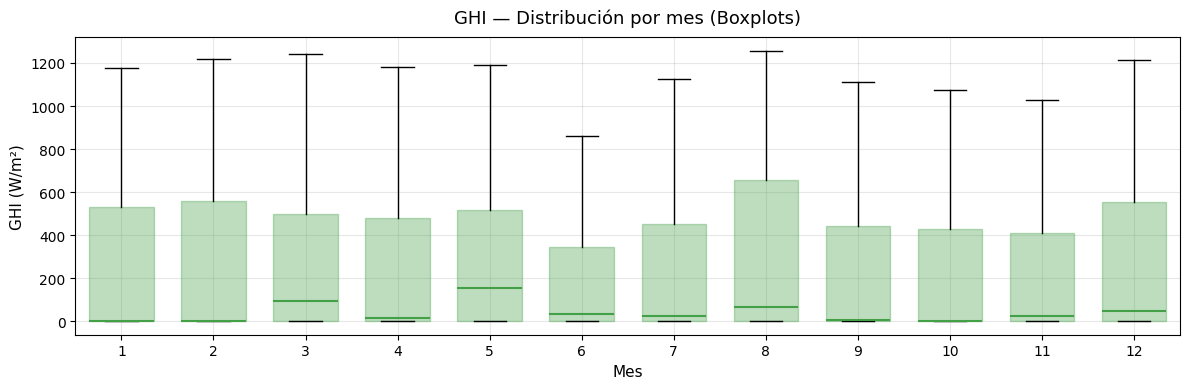

In [12]:
tmp = base.copy()
tmp["month"] = tmp.index.month
mat = [tmp.loc[tmp["month"]==m, "GHI"].dropna().values for m in range(1,13)]

fig, ax = plt.subplots(figsize=(12,4))
bp = ax.boxplot(mat, positions=np.arange(1,13), showfliers=False, widths=0.7,
                patch_artist=True)
for box in bp["boxes"]:
    box.set(facecolor="#43A047", alpha=0.35, edgecolor="#43A047")
for med in bp["medians"]:
    med.set(color="#43A047", linewidth=1.5)

ax.set_xticks(range(1,13))
ax.set_xlabel("Mes")
ax.set_ylabel("GHI (W/m²)")
ax.set_title("GHI — Distribución por mes (Boxplots)", pad=10)
fig.tight_layout()
fig.savefig(FIG_DIR / "ghi_boxplot_by_month.png")
plt.show()


C:\Users\Esteban\AppData\Local\Temp\ipykernel_17396\1281236858.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = pd.Series(yv).groupby(pd.cut(xv, bins)).median()


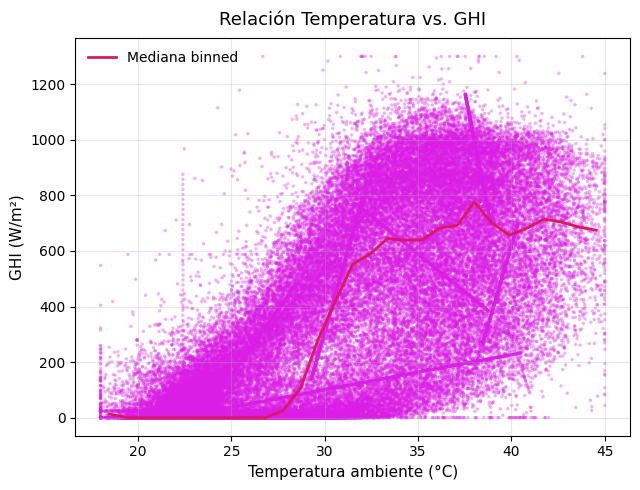

In [13]:
x = base["TempAmb"]
y = base["GHI"]
mask = x.notna() & y.notna()
xv, yv = x[mask], y[mask]

fig, ax = plt.subplots(figsize=(6.5,5))
ax.scatter(xv, yv, s=6, alpha=0.35, edgecolor="none")

# suavizado simple por bins
bins = np.linspace(xv.min(), xv.max(), 30)
centers = 0.5*(bins[1:]+bins[:-1])
binned = pd.Series(yv).groupby(pd.cut(xv, bins)).median()
ax.plot(centers, binned.values, lw=2, color="#D81B60", label="Mediana binned")

ax.set_xlabel("Temperatura ambiente (°C)")
ax.set_ylabel("GHI (W/m²)")
ax.legend(frameon=False)
ax.set_title("Relación Temperatura vs. GHI", pad=10)
fig.tight_layout()
fig.savefig(FIG_DIR / "scatter_temp_vs_ghi.png")
plt.show()


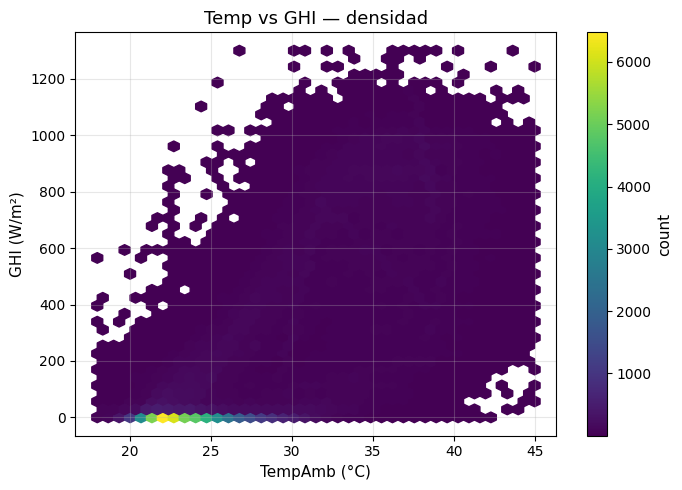

In [19]:
plt.figure(figsize=(7,5))
plt.hexbin(xv, yv, gridsize=40, mincnt=1, cmap="viridis")
plt.colorbar(label="count")
plt.xlabel("TempAmb (°C)"); plt.ylabel("GHI (W/m²)")
plt.title("Temp vs GHI — densidad")
plt.tight_layout()

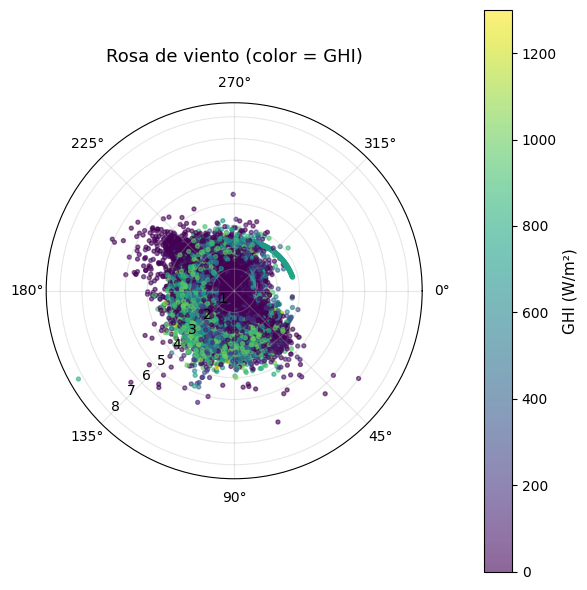

In [21]:
# Con Wind X/Y (componentes). Ajusta nombres si difieren.
wx = base["Wind X"]; wy = base["Wind Y"]; ghi = base["GHI"]; ws = base["WindSpeed"]
mask = wx.notna() & wy.notna() & ghi.notna()
wx, wy, ghi = wx[mask], wy[mask], ghi[mask]

# dirección y velocidad a partir de componentes
theta = np.arctan2(wy, wx)            # radianes, referencia eje x
theta = np.mod(theta, 2*np.pi)         # 0..2pi
speed = ws #np.hypot(wx, wy)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection="polar")
sc = ax.scatter(theta, speed, c=ghi, s=8, cmap="viridis", alpha=0.6)
cbar = fig.colorbar(sc, ax=ax, pad=0.12)
cbar.set_label("GHI (W/m²)")

ax.set_theta_zero_location("E")   # 0° en eje x positivo
ax.set_theta_direction(-1)        # sentido horario (estilo meteo)
ax.set_rlabel_position(135)

ax.set_title("Rosa de viento (color = GHI)", pad=10)
fig.tight_layout()
fig.savefig(FIG_DIR / "wind_rose_scatter_ghi.png")
plt.show()


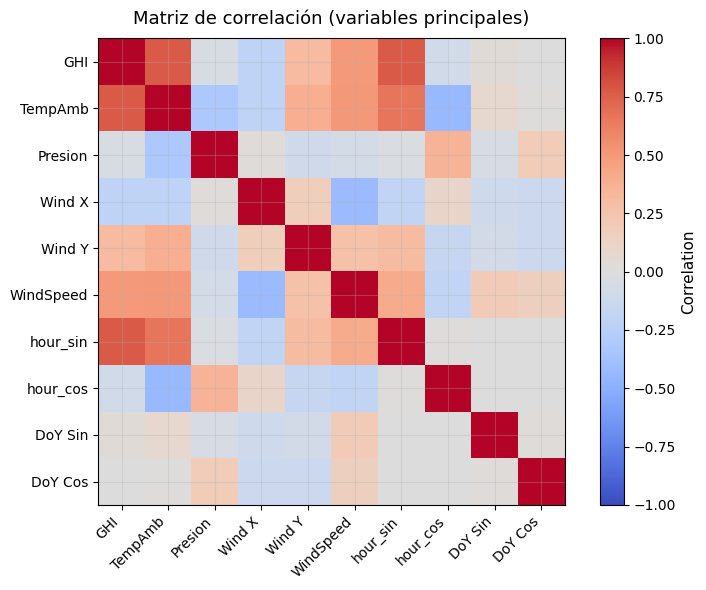

In [20]:
# --- Correlaciones ---
cols_interest = [
    "GHI", "TempAmb", "Presion",
    "Wind X", "Wind Y", "WindSpeed",
    "hour_sin", "hour_cos",
    "DoY Sin", "DoY Cos"
]
corr = base[cols_interest].corr()

plt.figure(figsize=(8,6))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Matriz de correlación (variables principales)", pad=10)
plt.tight_layout()
plt.show()

## Export

In [15]:
base.head()

,CSI,GHI,Presion,TempAmb,Wind Y,Wind X,DoY Sin,DoY Cos,horas,__missing_target,...,Presion_roll1h_max,WindSpeed_roll1h_mean,WindSpeed_roll3h_mean,WindSpeed_roll6h_mean,WindSpeed_roll1h_max,GHI_lag1,GHI_lag3,GHI_lag6,GHI_lag12,GHI_lag36
time,,,,,,,,,,,,,,,,,,,,,
2022-02-21 18:00:00+00:00,2.0,3.0352,1000.7912,29.9672,2.832954,-0.093612,0.778764,0.627317,18,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-21 18:10:00+00:00,0.0,0.3562,1000.9321,29.5689,3.387552,0.796801,0.778764,0.627317,18,False,...,NaN,NaN,NaN,NaN,NaN,3.0352,NaN,NaN,NaN,NaN
2022-02-21 18:20:00+00:00,0.0,0.0000,1001.1479,29.2593,2.091197,-0.878680,0.778764,0.627317,18,False,...,1001.1479,2.860933,NaN,NaN,3.48,0.3562,NaN,NaN,NaN,NaN
2022-02-21 18:30:00+00:00,0.0,0.0000,1001.2992,28.9183,-0.487957,-1.478562,0.778764,0.627317,18,False,...,1001.2992,2.534950,NaN,NaN,3.48,0.0000,3.0352,NaN,NaN,NaN
2022-02-21 18:40:00+00:00,0.0,0.0000,1001.4676,28.5578,0.891171,-2.047462,0.778764,0.627317,18,False,...,1001.4676,2.474560,NaN,NaN,3.48,0.0000,0.3562,NaN,NaN,NaN


In [16]:
df.head()

,CSI,GHI,Presion,TempAmb,Wind Y,Wind X,DoY Sin,DoY Cos,horas,__missing_target,flag_GHI_range,flag_TempAmb_range,flag_Presion_range,flag_CSI_range
time,,,,,,,,,,,,,,
2022-02-21 18:00:00+00:00,2.0,3.0352,1000.7912,29.9672,2.832954,-0.093612,0.778764,0.627317,18,False,False,False,False,False
2022-02-21 18:10:00+00:00,0.0,0.3562,1000.9321,29.5689,3.387552,0.796801,0.778764,0.627317,18,False,False,False,False,False
2022-02-21 18:20:00+00:00,0.0,0.0000,1001.1479,29.2593,2.091197,-0.878680,0.778764,0.627317,18,False,False,False,False,False
2022-02-21 18:30:00+00:00,0.0,0.0000,1001.2992,28.9183,-0.487957,-1.478562,0.778764,0.627317,18,False,False,False,False,False
2022-02-21 18:40:00+00:00,0.0,0.0000,1001.4676,28.5578,0.891171,-2.047462,0.778764,0.627317,18,False,False,False,False,False


In [ ]:
from pathlib import Path
CLEANDIR = Path("../data/clean"); CLEANDIR.mkdir(parents=True, exist_ok=True)


base.to_csv(CLEANDIR / "base_dataset.csv")
print("Saved:", CLEANDIR / "base_dataset.csv")


Saved: ..\data\clean\base_dataset.csv
